In [180]:
import jax
import jax.numpy as np
import matplotlib.pyplot as plt
from functools import partial
from jax.tree_util import (tree_flatten, tree_unflatten, treedef_is_leaf,
                           tree_map)

from jax.lax import fori_loop, while_loop, scan
# from jax import jit

# Should be >=0.3.20 for `jax.debug` package
print(jax.__version__)

def jit(f):
    return f

def fori_loop(lower, upper, body_fun, init_val):
    val = init_val
    for i in range(lower, upper):
        val = body_fun(i, val)
    return val


def while_loop(cond_fun, body_fun, init_val):
    val = init_val
    while cond_fun(val):
        val = body_fun(val)
    return val


def scan(f, init, xs, length=None):
    xs_flat, xs_tree = tree_flatten(xs)
    carry = init
    ys = []
    length = len(xs_flat[0])
    for i in range(length):
        xs_slice = [x[i] for x in xs_flat]
        carry, y = f(carry, tree_unflatten(xs_tree, xs_slice))
        ys.append(y)
    stack = lambda *ys: jax.numpy.stack(ys)
    stacked_y = tree_map(stack, *ys)
    return carry, stacked_y

# test scan
def foo(carry, i):
    return (0, 0), (1, 2)

scan(foo, (0, 0), np.arange(10))
scan(foo, (0, 0), (np.arange(10), np.arange(20, 30)))

0.3.20


((0, 0),
 (DeviceArray([1, 1, 1, 1, 1, 1, 1, 1, 1, 1], dtype=int32, weak_type=True),
  DeviceArray([2, 2, 2, 2, 2, 2, 2, 2, 2, 2], dtype=int32, weak_type=True)))

In [126]:
tau_syn = 5e-4
tau_mem = 1e-3

tau_mem_inv = 1.0 / tau_mem
tau_syn_inv = 1.0 / tau_syn

A = np.array([[-tau_mem_inv, tau_mem_inv], [0,-tau_syn_inv]])

def f(A, x0, t):
  return np.dot(jax.scipy.linalg.expm(A * t), x0)

dynamics = partial(f, A)
batched_dynamics = jax.vmap(dynamics, in_axes=(0, None))

In [127]:
y0 = np.array([0.0, 1.0])
xs = np.arange(0, 5e-3, 1e-5)
ys = jax.vmap(partial(dynamics, y0))(xs)

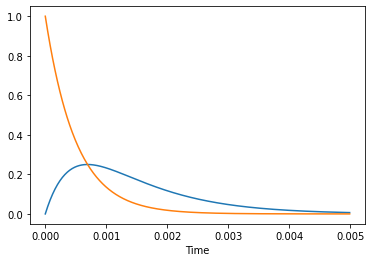

In [128]:
plt.xlabel('Time')
plt.plot(xs, ys)

In order to determine whether any jump had occured it is sufficient to focus on a given time interval $[t_k, t_{k+1}]$, we can then consider a jump condition $j$, for example one that is affine
$$j(t) = P y(t) - b$$
and do a root finding procedure on this interval.

In [129]:
# c.f.: https://github.com/google/jax/issues/8744
def newton(f, y0, x0):
  """Newton's method for root-finding."""
  initial_state = (0, x0)

  def cond(state):
    it, x = state
    return (it < 10)

  def body(state):
    it, x = state
    fx, dfx = f(y0, x), jax.grad(f, argnums=1)(y0, x)
    step = fx / dfx
    new_state = it + 1, x - step
    return new_state

  res = jax.lax.while_loop(
    cond,
    body,
    initial_state,
  )[1]
  return np.where(res > 0, res, np.nan)

In [130]:
# c.f.: https://github.com/google/jax/issues/8744

def newton(f, y0, initial_guess):
  """Newton's method for root-finding."""
  initial_state = (initial_guess)

  def body(x, it):
    fx, dfx = f(y0, x), jax.grad(f, argnums=1)(y0, x)
    step = fx / dfx
    return x - step, 0

  res = jax.lax.scan(body, initial_state, np.arange(6))[0]
  return np.where(res > 0, res, np.nan)

In [131]:
def ttfs(v_th, state, y0):
    v_0, i_0 = state
    a_1 = i_0
    a_2 = v_0 + i_0
    T = tau_mem * np.log(2*a_1 / (a_2 + np.sqrt(a_2**2 - 4*a_1 * v_th)))
    return T

0.00020306182


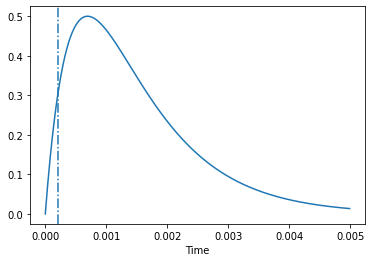

In [132]:
y0 = np.array([0.0, 2.0])
xs = np.arange(0, 5e-3 ,1e-5)
v_th = 0.3


def jump_condition(dynamics, v_th, x0, t):
  return dynamics(x0, t)[0] - v_th # this implements the P y(t) - b above


jc = partial(jump_condition, dynamics, v_th)
ys = jax.vmap(partial(dynamics, y0))(xs)[:, 0]

newton_solver = jax.jit(partial(newton, jc))
ttfs_solver = jax.jit(partial(ttfs, v_th))

spike_time = newton_solver(y0, 1e-4)
spike_time = ttfs_solver(y0, 1e-4)

print(spike_time)

# %timeit newton_solver(y0, 1e-4)
# %timeit ttfs_solver(y0, 1e-4)

plt.xlabel('Time')
plt.plot(xs, ys)
plt.axvline(spike_time, linestyle='-.')

In [133]:
# let's wrap the newton solver with custom root

def custom_newton(f, initial_guess):
  """Newton's method for root-finding."""
  initial_state = (initial_guess)

  def body(x, it):
    fx, dfx = f(x), jax.grad(f)(x)
    step = fx / dfx
    return x - step, 0

  res = jax.lax.scan(body, initial_state, np.arange(6))[0]
  return np.where(res > 0, res, np.nan)


def tangent_solve(g, y):
    return y / g(1.0)

solve = custom_newton

@jax.jit
def wrapped_newton_solver(y0, initial_guess):
    f = partial(jc, y0)
    return jax.lax.custom_root(f, initial_guess, solve, tangent_solve)

In [134]:
# do this for two neurons
y0 = np.array([[0.0, 1.0], [0.1, 1.0], [0.0, 0.0]])
batched_newton_solver = jax.jit(jax.vmap(newton_solver, in_axes=(0, None)))
batched_wrapped_newton_solver = jax.jit(jax.vmap(wrapped_newton_solver, in_axes=(0, None)))
batched_ttfs_solver = jax.jit(jax.vmap(ttfs_solver, in_axes=(0, None)))

spike_times = batched_ttfs_solver(y0, 1e-4)
print(spike_times)
# %timeit batched_newton_solver(y0, 1e-4)
# %timeit batched_wrapped_newton_solver(y0, 1e-4)
# %timeit batched_ttfs_solver(y0, 1e-4)

[       nan 0.00051083        nan]


In [135]:
# check that nevative spike times return nan
assert np.isnan(ttfs_solver(np.array([0.0, 0.1]), 1e-4))
assert np.isnan(newton_solver(np.array([0.0, 0.1]), 1e-4))

In [136]:
def single_tr_equation(weights, x, spike_idx):
  i_new = x[1] + weights[0]
  return np.array([0.0, i_new])

def tr_equation(weights, x, spike_idx):
  x = x.at[spike_idx, 0].set(0.0)
  i_new = x[:, 1] + weights[spike_idx, :]
  return np.stack((x[:, 0], i_new), axis=1)


def step(dynamics, solver, tr_dynamics, weights, y, dt):
  t_spike = solver(y, 1e-4)

  # only integrate to next boundary
  spike_idx = np.nanargmin(t_spike)
  no_spike = spike_idx == -1
  t_dyn = jax.lax.cond(no_spike, lambda: dt, lambda: t_spike[spike_idx])
  y_minus = dynamics(y, t_dyn)

  true_fun = lambda weights, y_minus, spike_idx: y_minus
  false_fun = tr_dynamics
  args = (weights, y_minus, spike_idx)
  y_plus = jax.lax.cond(no_spike, true_fun, false_fun, *args)

  return y_plus, t_dyn, spike_idx

In [137]:
# but how can we feed input spikes into the net?
# we start with maximal one input spike per layer
y0 = np.array([[0.0, 0.0], [0.0, 0.2], [0.0, 0.0]])
input_spikes = np.array([1e-4, 3e-4, np.inf])

t_spike = batched_ttfs_solver(y0, 1e-3)
print(f"Next spike at: {np.min(t_spike)}")

t_spike = np.where(np.isnan(t_spike), np.inf, t_spike)
merged = np.minimum(t_spike, input_spikes)
next_spike_idx = np.argmin(merged)
next_spike_time = merged[next_spike_idx]
print(f"Next spike from neuron {next_spike_idx} at {next_spike_time}")

# but we only want to take input spikes that are still in the future
# suppose our current time is t
t = 2e-4
input_spikes = np.where(input_spikes > t, input_spikes, np.inf)  # type: ignore
merged = np.minimum(t_spike, input_spikes)
next_spike_idx = np.argmin(merged)
next_spike_time = merged[next_spike_idx]
print(f"Next spike from neuron {next_spike_idx} at {next_spike_time}")

# this also works. But what is returned if no next spike is coming up?
t = 5e-4
input_spikes = np.where(input_spikes > t, input_spikes, np.inf)  # type: ignore
merged = np.minimum(t_spike, input_spikes)
next_spike_idx = np.argmin(merged)
next_spike_time = merged[next_spike_idx]
print(f"Next spike from neuron {next_spike_idx} at {next_spike_time}")


Next spike at: nan
Next spike from neuron 0 at 9.999999747378752e-05
Next spike from neuron 1 at 0.0003000000142492354
Next spike from neuron 0 at inf


In [181]:
# so we can rewrite the step function
def step(dynamics, solver, tr_dynamics, weights, input_spikes, y, dt):
  t_spike = solver(y, 1e-4)

  # replace nan by inf, TODO: solver should return inf instead of nan
  t_spike = np.where(np.isnan(t_spike), np.inf, t_spike)

  # combined 'external' and 'internal' spikes
  # only regard future input spikes
  input_spikes = np.where(input_spikes > 0.0, input_spikes, np.inf)  # type: ignore
  combined = np.minimum(t_spike, input_spikes)
  spike_idx = np.argmin(combined)
  spike_time = combined[spike_idx]

  no_spike = spike_time == np.inf
  # update spike idx
  spike_idx = jax.lax.cond(no_spike, lambda: -1, lambda: spike_idx)
  t_dyn = np.minimum(spike_time, dt)
  y_minus = dynamics(y, t_dyn)

  true_fun = lambda weights, y_minus, spike_idx: y_minus
  false_fun = tr_dynamics
  args = (weights, y_minus, spike_idx)
  y_plus = jax.lax.cond(no_spike, true_fun, false_fun, *args)

  return y_plus, t_dyn, spike_idx

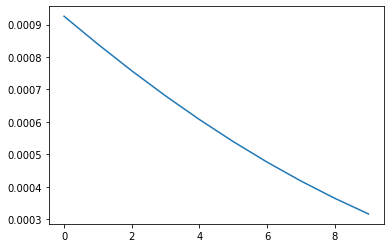

In [182]:
# train two neurons
# train one neuron with a target spike time for the second spike

n_neurons = 2
weights = (1 - np.eye(n_neurons)) * 3.0  # type: ignore

step_fn = partial(step, batched_dynamics, batched_ttfs_solver, tr_equation)
input_spikes = np.array([0.001, np.inf])
y = np.array([[0.0, 0.0], [0.0, 0.0]])
dt = 0.1

def first_spike(weights, y):
    y, dt, spike_idx = step_fn(weights, input_spikes, y, 0.1)
    y, dt, spike_idx = step_fn(weights, input_spikes - dt, y, 0.1)
    return ((0.00015 - dt) / tau_mem) ** 2

loss = []
for i in range(10):
    value, grad = jax.value_and_grad(first_spike)(weights, y)
    loss.append(value)
    weights = weights - 10 * grad

plt.plot(np.arange(len(loss)), loss)
plt.show()

In [139]:
n_neurons = 3
weights = (1 - np.eye(n_neurons)) * 3.0  # type: ignore

y = np.zeros((n_neurons, 2))
input_spikes = np.array([1e-4, np.inf, np.inf])

step_fn = jit(partial(step, batched_dynamics, batched_wrapped_newton_solver, tr_equation))
y_plus, dt, spike_idx = step_fn(weights, input_spikes, y, 0.1)
print(f"Neuron {spike_idx} spiked at {dt:.5f}")

# second run
y_plus, dt, spike_idx = step_fn(weights, input_spikes - dt, y_plus, 0.1)
print(f"Neuron {spike_idx} spiked at {dt:.5f}")

%timeit step_fn(weights, input_spikes, y, 0.1)

Neuron 0 spiked at 0.00010
Neuron 1 spiked at 0.00012
37.1 ms ± 649 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [183]:
def forward_integration(
      step_fn,
      n_spikes,
      weights,
      initial_state,
      input_spikes,
      t_max,
    ):
  
  def body(state, it):
    t, y = state  # t is current lower bound
   
    dt = t_max - t
    y_plus, dt_dyn, spike_idx = step_fn(weights, input_spikes - t, y, dt)
    
    t = t + dt_dyn
    state = (t, y_plus)
    return state, (t, spike_idx)

  t = 0
  return scan(body, (t, initial_state), np.arange(n_spikes))

# forward = jit(partial(forward_integration, step_fn, 10))
# forward(weights, y, input_spikes, 0.1)
# %timeit forward(weights, y, input_spikes, 0.1)

In [184]:
def init_weights(rng, n_neurons):
  off_diagonal = (1 - np.eye(n_neurons))
  weights = jax.random.uniform(rng, (n_neurons, n_neurons)) * 3.0
  return off_diagonal * weights


def first_spike(spikes, idx):
    """Return spike times"""
    spike_times, spike_idx = spikes
    output_idx = np.where(spike_idx == idx)[0]
    return spike_times[output_idx][0]

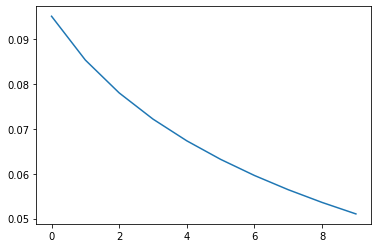

In [185]:
# now again train two neurons with the forward integration functino

n_neurons = 4
n_spikes = 10
rng = jax.random.PRNGKey(42)
weights = init_weights(rng, n_neurons)

step_fn = partial(step, batched_dynamics, batched_wrapped_newton_solver, tr_equation)
forward = jit(partial(forward_integration, step_fn, n_spikes))
input_spikes = np.array([1e-4, 1.2e-4, np.inf, np.inf])
y = np.zeros((n_neurons, 2))

def loss_fn(weights, y):
    state, spikes = forward(weights, y, input_spikes, 0.1)
    pred = np.array([first_spike(spikes, 2), first_spike(spikes, 3)])
    target = np.array([0.00035, 0.00025])
    return np.sum((np.abs((pred - target) / tau_mem)))


def loss_count_fn(weights, y):
    # this does not work for some reason
    state, spikes = forward(weights, y, input_spikes, 0.1)
    spike_times, spike_idx = spikes
    pred = np.array([np.count_nonzero(spike_idx == 2), np.count_nonzero(spike_idx == 3)])
    target = np.array([5.0, 0.0])
    return np.sum((pred - target) ** 2)  # type: ignore

loss = []
grad_fn = jax.value_and_grad(loss_fn)
lr = 1.0
for i in range(10):
    value, grad = grad_fn(weights, y)
    loss.append(value)
    lr *= 0.98
    weights = weights - lr * np.where(np.isnan(grad), 0.0, grad)  # type: ignore

plt.plot(np.arange(len(loss)), loss)
plt.show()

In [116]:
n_neurons = 3
rng = jax.random.PRNGKey(42)
weights = init_weights(rng, n_neurons)
input_spikes = np.array([0.001, 0.002, np.inf])
n_spikes = 10

t_max = 20 * tau_mem
initial_state = np.zeros((n_neurons, 2))

forward = jit(partial(forward_integration, step_fn, n_spikes))
(t, y), spikes = forward(weights, initial_state, input_spikes, t_max)

# %timeit forward(weights, initial_state, input_spikes, t_max)

spike_times, spike_idx = spikes
spike_times = spike_times[spike_idx >= 0]
spike_idx = spike_idx[spike_idx >= 0]
print(f"{len(spike_times)} spikes: {len(spike_idx[spike_idx == 0]), len(spike_idx[spike_idx == 1]), len(spike_idx[spike_idx == 2])}")

10 spikes: (5, 3, 2)


In [186]:
# Let's check if we have a valid gradient for the first spike time with regards to the weights
weights = init_weights(rng, n_neurons)
initial_state = np.zeros((n_neurons, 2))

def objective(weights, neuron_idx):
    (t, y), (spikes) = forward(weights, initial_state, input_spikes, t_max)
    return first_spike(spikes, neuron_idx)

# why do we not have a valid gradient?
jax.value_and_grad(objective)(weights, 3)

(DeviceArray(0.00023926, dtype=float32),
 DeviceArray([[           nan,            nan,            nan,
               -6.5681597e-05],
              [           nan,  0.0000000e+00,            nan,
               -5.7949215e-05],
              [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
                0.0000000e+00],
              [ 0.0000000e+00,  0.0000000e+00,  0.0000000e+00,
                0.0000000e+00]], dtype=float32))

In [187]:
# let's do forward for a batch of input spikes 
batched_forward = jax.vmap(forward, in_axes=(None, None, 0, None))
batched_input = np.repeat(input_spikes[None, :], 10, axis=0)  # type: ignore
(t, y), (spike_times, spike_idx) = batched_forward(weights, initial_state, batched_input, t_max)
print(spike_times.shape)

(10, 10)


In [227]:
def loss_and_spikes(weights, batch):
  input_spikes, target = batch
  t_max = 100 * tau_mem
  initial_state = np.zeros((weights.shape[0], 2))
  (t, y), (spike_times, spike_idx) = forward(weights, initial_state, input_spikes, t_max)

  min_ix1 = np.nanargmin(np.where(spike_idx == 2, spike_times, np.nan))
  min_ix2 = np.nanargmin(np.where(spike_idx == 3, spike_times, np.nan))
  min_ix = np.array([min_ix1, min_ix2])
  assert not np.any(min_ix == -1)
  jax.debug.print(f"Min ix: {min_ix}")
  min_spike_time = spike_times[min_ix]
  loss_value = np.sum(np.log(1 + np.exp(-(min_spike_time - target)**2 / tau_mem))) * tau_mem_inv
  return loss_value, (spike_times, spike_idx)


def update(weights, batch):
  (loss, spikes), grad = jax.value_and_grad(loss_and_spikes, has_aux=True)(weights, batch)  # type: ignore
  weights = jax.tree_map(lambda f, df: f - df, weights, np.where(np.isnan(grad), 0, grad))
  return weights, (loss, spikes)

In [228]:
# now again train two neurons with the forward integration functino

n_neurons = 4
n_spikes = 20
rng = jax.random.PRNGKey(42)
weights = init_weights(rng, n_neurons)

step_fn = partial(step, batched_dynamics, batched_wrapped_newton_solver, tr_equation)
forward = jit(partial(forward_integration, step_fn, n_spikes))
input_spikes = np.array([1e-4, 1.2e-4, np.inf, np.inf])
y = np.zeros((n_neurons, 2))

# def loss_fn(weights, y):
#     state, spikes = forward(weights, y, input_spikes, 0.1)
#     pred = np.array([first_spike(spikes, 2), first_spike(spikes, 3)])
#     target = np.array([0.00035, 0.00025])
#     return np.sum((np.abs((pred - target) / tau_mem)))


# def loss_count_fn(weights, y):
#     # this does not work for some reason
#     state, spikes = forward(weights, y, input_spikes, 0.1)
#     spike_times, spike_idx = spikes
#     pred = np.array([np.count_nonzero(spike_idx == 2), np.count_nonzero(spike_idx == 3)])
#     target = np.array([5.0, 0.0])
#     return np.sum((pred - target) ** 2)  # type: ignore

# loss = []
# grad_fn = jax.value_and_grad(loss_fn)
# lr = 1.0
# for i in range(10):
#     value, grad = grad_fn(weights, y)
#     loss.append(value)
#     lr *= 0.98
#     weights = weights - lr * np.where(np.isnan(grad), 0.0, grad)  # type: ignore

# plt.plot(np.arange(len(loss)), loss)
# plt.show()

In [229]:
# let's train for multiple epochs
n_neurons = 4
epochs = 20
weights = init_weights(rng, n_neurons) * 2.0

input_spikes = np.array([0.001, 0.0014, np.inf, np.inf])
input_spikes = np.repeat(input_spikes[None, :], epochs, axis=0)  # type: ignore

target_times = np.array([2 * tau_mem, 6 * tau_mem])
target_times = np.repeat(target_times[None, :], epochs, axis=0)  # type: ignore
weights, (loss, spikes) = scan(update, weights, (input_spikes, target_times))

Min ix: [9 1]
Min ix: [9 1]
Min ix: [9 1]
Min ix: [9 1]
Min ix: [9 1]
Min ix: [9 1]
Min ix: [9 1]
Min ix: [9 1]
Min ix: [9 1]
Min ix: [9 1]
Min ix: [9 1]
Min ix: [9 1]
Min ix: [9 1]
Min ix: [9 1]
Min ix: [9 1]
Min ix: [9 1]
Min ix: [9 1]
Min ix: [9 1]
Min ix: [9 1]
Min ix: [9 1]


In [223]:
loss

DeviceArray([0.37094116, 0.34853786, 0.3422616 , 0.33821583, 0.3363318 ,
             0.33509645, 0.3341863 , 0.33347175, 0.33288777, 0.33239684],            dtype=float32)

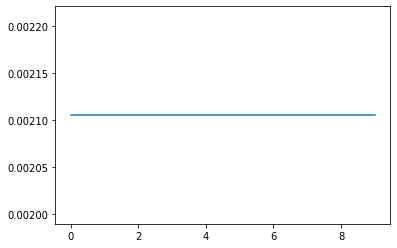

In [73]:
spike_times, spike_idx = spikes

output_idx = np.nanargmin(np.where(spike_idx == 3, spike_idx, np.nan), axis=1)
output_time = spike_times[np.arange(10), output_idx]

plt.plot(np.arange(len(output_time)), output_time)
plt.show()

In [162]:
# create a circular dataset
def dataset(key, batch_size, n_samples):
    r = 1
    t_late = 3 * tau_syn
    x = jax.random.uniform(key, (n_samples, batch_size, 2))
    y = np.where(x[:,:,0] - x[:,:,1] > 1, 1, 0)
    one_hot = np.array([[0.0, tau_mem], [tau_mem, 0.0]])[y]  # type: ignore
    return x * t_late, one_hot


# define a loss
def loss(recording):
    # first spike time
    recording[0, 0]
    # x, y = batch
    # t_spike = jax.vmap(apply_fn, in_axes=(None, 0))(weights, x)
    # return np.sum(jax.vmap(loss_fn, in_axes=(0, 0))(t_spike, y))
    pass

In [163]:
rng = jax.random.PRNGKey(42)
rng, weight_rng = jax.random.split(rng)
n_neurons = 100

weights = jax.random.uniform(rng, (n_neurons, n_neurons))
x, y = dataset(rng, 10, 100)